In [1]:
#from https://www.datacamp.com/community/tutorials/autoencoder-classifier-python#import keras
import os
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.image import central_crop
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.utils import to_categorical
import cv2
from numpy import savez_compressed

from pprint import pprint

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_logical_devices('GPU')


Using TensorFlow backend.


Num GPUs Available:  2


In [2]:
image_size = 128
print(image_size)
## load data of converted images from NPZ
X_train = np.load("X_train-pneunonia-grayscale-(5216, 288, 288, 1).npz")['arr_0']
y_train = np.load("Y_train-pneunonia-grayscale-(5216, 288, 288, 1).npz")['arr_0']
X_val = np.load("X_val-pneunonia-grayscale-(16, 288, 288, 1).npz")['arr_0']
y_val = np.load("Y_val-pneunonia-grayscale-(16, 288, 288, 1).npz")['arr_0']
X_test = np.load("X_test-pneunonia-grayscale-(624, 288, 288, 1).npz")['arr_0']
y_test = np.load("Y_test-pneunonia-grayscale-(624, 288, 288, 1).npz")['arr_0']
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)
y_valHot = to_categorical(y_val, num_classes = 2)


128


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5216, 288, 288, 1)
(5216,)
(624, 288, 288, 1)
(624,)


In [4]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
print(X_trainShape)
print(X_testShape)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
print(X_trainFlat.shape)
print(X_testFlat.shape)

82944
82944
(5216, 82944)
(624, 82944)


In [5]:
src_size  = 288
#ros = RandomOverSampler(sampling_strategy='auto')
ros = RandomUnderSampler(sampling_strategy='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
# Make Data 2D again
height, width, channels = src_size,src_size,1
for i in range(len(X_trainRos)):
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)


{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


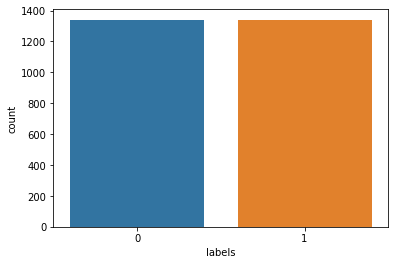

In [6]:
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
distRos = lab.value_counts()
# Plot Label Distribution
import seaborn
seaborn.countplot(labRos)
print({0: 'No Pneumonia', 1: 'Yes Pneumonia'})

In [7]:
print(X_testRosReshaped.shape)

(468, 288, 288, 1)


In [8]:
train_data = X_trainRosReshaped
test_data = X_testRosReshaped
print(train_data.shape)
print(test_data.shape)



(2682, 288, 288, 1)
(468, 288, 288, 1)


In [9]:

train_labels = y_train
test_labels = y_test


In [10]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))
image_size = 288

Training set (images) shape: (2682, 288, 288, 1)
Test set (images) shape: (468, 288, 288, 1)


Text(0.5, 1.0, '(Label: No)')

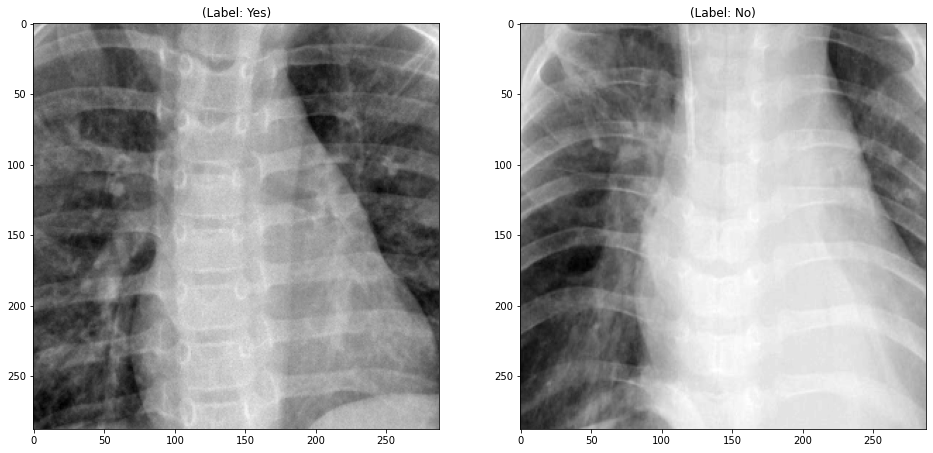

In [11]:
# Create dictionary of target classes
label_dict = {
 0: 'No',
 1: 'Yes'
}
plt.figure(figsize=[16,16])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (image_size,image_size))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[-20], (image_size,image_size))
curr_lbl = test_labels[-20]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [12]:
train_data = train_data.reshape(-1, image_size,image_size, 1)
test_data = test_data.reshape(-1, image_size,image_size, 1)
train_data.shape, test_data.shape

((2682, 288, 288, 1), (468, 288, 288, 1))

In [13]:
train_data.dtype, test_data.dtype

(dtype('int32'), dtype('int32'))

In [14]:
np.max(train_data), np.max(test_data)

(255, 255)

In [15]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [16]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [17]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)
from pprint import pprint
pprint(train_X.shape)
pprint(valid_X.shape)
pprint(train_ground.shape)
pprint(valid_ground.shape)

(2145, 288, 288, 1)
(537, 288, 288, 1)
(2145, 288, 288, 1)
(537, 288, 288, 1)


In [18]:
from tensorflow.image import resize as reZ

In [19]:
x, y = 128, 128
inChannel = 1

with tf.device('/CPU'):
    train_X = reZ(train_X,(128,128))
    print(train_X.shape)
    valid_X =reZ(valid_X,(128,128))
    print(valid_X.shape)
    train_ground = reZ(train_ground,(128,128))
    print(train_ground.shape)
    valid_ground = reZ(valid_ground,(128,128))
    print(valid_ground.shape)

batch_size = 16
epochs = 64


input_img = Input(shape = (x, y, inChannel),dtype='float32')
print(input_img)
#tf.set_floatx('float16')
num_classes = 2

(2145, 128, 128, 1)
(537, 128, 128, 1)
(2145, 128, 128, 1)
(537, 128, 128, 1)
Tensor("input_1:0", shape=(None, 128, 128, 1), dtype=float32)


In [20]:
print(num_classes)


2


In [21]:
def encoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #image_size x image_size x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [23]:
#with tf.device('/GPU:1'):
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(lr=0.0005))


In [24]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        1849

In [25]:
#with tf.device('/GPU:1'):
autoencoder_train = autoencoder.fit(train_X,train_ground, batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(valid_X,valid_ground))
autoencoder.save_weights("autoencoder128.h5")

Epoch 1/64
135/135 - 33s - loss: 0.0067 - val_loss: 0.0303
Epoch 2/64
135/135 - 28s - loss: 0.0024 - val_loss: 0.0178
Epoch 3/64
135/135 - 28s - loss: 0.0017 - val_loss: 0.0039
Epoch 4/64
135/135 - 28s - loss: 0.0017 - val_loss: 0.0024
Epoch 5/64
135/135 - 28s - loss: 0.0014 - val_loss: 0.0033
Epoch 6/64
135/135 - 28s - loss: 0.0015 - val_loss: 0.0205
Epoch 7/64
135/135 - 28s - loss: 0.0013 - val_loss: 0.0038
Epoch 8/64
135/135 - 28s - loss: 0.0012 - val_loss: 0.0032
Epoch 9/64
135/135 - 28s - loss: 0.0011 - val_loss: 0.0420
Epoch 10/64
135/135 - 28s - loss: 0.0013 - val_loss: 0.0016
Epoch 11/64
135/135 - 28s - loss: 0.0010 - val_loss: 0.0018
Epoch 12/64
135/135 - 28s - loss: 0.0011 - val_loss: 7.6557e-04
Epoch 13/64
135/135 - 28s - loss: 0.0012 - val_loss: 0.0011
Epoch 14/64
135/135 - 28s - loss: 0.0010 - val_loss: 0.0018
Epoch 15/64
135/135 - 28s - loss: 0.0010 - val_loss: 0.0020
Epoch 16/64
135/135 - 28s - loss: 9.9780e-04 - val_loss: 0.0035
Epoch 17/64
135/135 - 28s - loss: 0.0010 

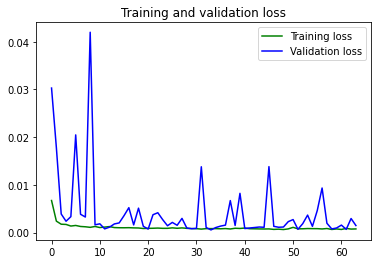

In [26]:

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_R = range(epochs)
plt.figure()
plt.plot(epochs_R, loss, 'g', label='Training loss')
plt.plot(epochs_R, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [27]:
# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', y_trainHot[0])

Original label: 1
After conversion to one-hot: [0. 1.]


In [28]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4


In [29]:
#autoencoder.load_weights("autoencoder288.h5")

y_valHot = to_categorical(y_val, num_classes = 2)

print(X_trainRosReshaped.shape)
print(Y_trainRosHot.shape)
print(X_test.shape)
print(y_testHot.shape)



(2682, 288, 288, 1)
(2682, 2)
(624, 288, 288, 1)
(624, 2)


In [42]:
train_X,valid_X,train_label,valid_label = reZ(X_trainRosReshaped,(128,128)),reZ(X_test,(128,128)),Y_trainRosHot,y_testHot
print(train_X.shape)
print(valid_X.shape)
print(train_ground.shape)
print(valid_ground.shape)


(2682, 128, 128, 1)
(624, 128, 128, 1)
(2145, 128, 128, 1)
(537, 128, 128, 1)


In [94]:
# split data for classification
train_X,valid_X,train_label,valid_label = train_test_split(train_data,Y_trainRosHot,test_size=0.2,random_state=13)

In [95]:
print(train_X.shape)
print(valid_X.shape)
print(train_label.shape)
print(valid_label.shape)

(2145, 288, 288, 1)
(537, 288, 288, 1)
(2145, 2)
(537, 2)


In [96]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(2, activation='sigmoid')(den)
    return out

In [97]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [98]:
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        1849

In [99]:
full_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_44 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 64, 64)        1849

In [100]:
i=0
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    pprint(l1)
    pprint(l2)
    print(i)
    i+=1
    l1.set_weights(l2.get_weights())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [101]:
autoencoder.get_weights()[0][1]

array([[[-1.02383643e-01,  1.55498702e-02, -1.74952522e-02,
          8.33730586e-03, -1.35160804e-01, -2.97148358e-02,
         -2.20603179e-02, -1.78532563e-02,  3.72283882e-03,
         -6.69938251e-02,  1.23755641e-01,  2.89282389e-02,
         -6.57714978e-02,  1.49943456e-01,  1.36587933e-01,
         -2.03376710e-02, -5.81738614e-02, -8.87712985e-02,
         -1.66281348e-03,  2.66459435e-01, -1.25214100e-01,
         -1.30843878e-01, -8.50026533e-02, -7.07233101e-02,
         -4.54366244e-02,  9.54486430e-02,  1.33079488e-03,
          4.99541312e-02,  5.83517812e-02, -2.78149527e-02,
          2.06819028e-01, -3.46611580e-03]],

       [[-1.40374042e-02, -2.18947046e-03, -3.26460823e-02,
         -5.26405126e-02, -1.26485124e-01, -1.23472989e-01,
          1.08726569e-01,  1.23390995e-01,  1.83720306e-01,
          7.57605210e-02, -6.94862679e-02,  1.28150642e-01,
          9.51166227e-02, -8.19818527e-02,  2.94327387e-04,
          2.71653850e-02, -1.27227798e-01, -1.61984209

In [102]:
full_model.get_weights()[0][1]

array([[[-1.02383643e-01,  1.55498702e-02, -1.74952522e-02,
          8.33730586e-03, -1.35160804e-01, -2.97148358e-02,
         -2.20603179e-02, -1.78532563e-02,  3.72283882e-03,
         -6.69938251e-02,  1.23755641e-01,  2.89282389e-02,
         -6.57714978e-02,  1.49943456e-01,  1.36587933e-01,
         -2.03376710e-02, -5.81738614e-02, -8.87712985e-02,
         -1.66281348e-03,  2.66459435e-01, -1.25214100e-01,
         -1.30843878e-01, -8.50026533e-02, -7.07233101e-02,
         -4.54366244e-02,  9.54486430e-02,  1.33079488e-03,
          4.99541312e-02,  5.83517812e-02, -2.78149527e-02,
          2.06819028e-01, -3.46611580e-03]],

       [[-1.40374042e-02, -2.18947046e-03, -3.26460823e-02,
         -5.26405126e-02, -1.26485124e-01, -1.23472989e-01,
          1.08726569e-01,  1.23390995e-01,  1.83720306e-01,
          7.57605210e-02, -6.94862679e-02,  1.28150642e-01,
          9.51166227e-02, -8.19818527e-02,  2.94327387e-04,
          2.71653850e-02, -1.27227798e-01, -1.61984209

In [103]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [104]:
full_model.compile(loss="binary_crossentropy", optimizer = Adam(),metrics=['acc', 'binary_accuracy'])

In [105]:
full_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_44 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 64, 64)        1849

In [109]:
print(train_X.shape)
print(valid_X.shape)
print(train_label)
print(valid_label)

(2145, 288, 288, 1)
(537, 288, 288, 1)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [111]:
classify_train = full_model.fit(reZ(train_X,(128,128)), train_label, batch_size=4,epochs=64,verbose=2,validation_data=(reZ(valid_X,(128,128)), valid_label))
full_model.save_weights("autoencoder_classification+2.h5")

Epoch 1/64
537/537 - 30s - loss: 0.0641 - acc: 0.9725 - binary_accuracy: 0.9725 - val_loss: 40.2929 - val_acc: 0.8808 - val_binary_accuracy: 0.8799
Epoch 2/64
537/537 - 30s - loss: 0.0682 - acc: 0.9720 - binary_accuracy: 0.9711 - val_loss: 40.3248 - val_acc: 0.8883 - val_binary_accuracy: 0.8873
Epoch 3/64
537/537 - 30s - loss: 0.0695 - acc: 0.9739 - binary_accuracy: 0.9734 - val_loss: 40.4852 - val_acc: 0.9032 - val_binary_accuracy: 0.9032
Epoch 4/64
537/537 - 30s - loss: 0.0833 - acc: 0.9744 - binary_accuracy: 0.9751 - val_loss: 41.6108 - val_acc: 0.9069 - val_binary_accuracy: 0.9078
Epoch 5/64
537/537 - 30s - loss: 0.0640 - acc: 0.9786 - binary_accuracy: 0.9786 - val_loss: 41.8714 - val_acc: 0.9069 - val_binary_accuracy: 0.9078
Epoch 6/64
537/537 - 30s - loss: 0.0394 - acc: 0.9823 - binary_accuracy: 0.9823 - val_loss: 42.1854 - val_acc: 0.8976 - val_binary_accuracy: 0.8985
Epoch 7/64
537/537 - 30s - loss: 0.1818 - acc: 0.9683 - binary_accuracy: 0.9669 - val_loss: 41.5289 - val_acc: 0

537/537 - 30s - loss: 0.0091 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 43.0915 - val_acc: 0.9143 - val_binary_accuracy: 0.9143
Epoch 57/64
537/537 - 30s - loss: 0.0091 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 43.0960 - val_acc: 0.9143 - val_binary_accuracy: 0.9143
Epoch 58/64
537/537 - 30s - loss: 0.0091 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 43.1009 - val_acc: 0.9143 - val_binary_accuracy: 0.9143
Epoch 59/64
537/537 - 30s - loss: 0.0091 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 43.1054 - val_acc: 0.9125 - val_binary_accuracy: 0.9125
Epoch 60/64
537/537 - 30s - loss: 0.0091 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 43.1100 - val_acc: 0.9125 - val_binary_accuracy: 0.9125
Epoch 61/64
537/537 - 30s - loss: 0.0091 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 43.1143 - val_acc: 0.9125 - val_binary_accuracy: 0.9125
Epoch 62/64
537/537 - 30s - loss: 0.0091 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 43.1210 - val_acc: 0.9125

In [ ]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-Autoencoder+2.hdf5"
weights_improvement = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [EarlyStopping(monitor='val_acc', patience=3, verbose=1),weights_improvement]

In [119]:
for layer in full_model.layers[0:19]:
    layer.trainable = True
full_model.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy'])
classify_train1 = full_model.fit(reZ(train_X,(128,128)), train_label, batch_size=4,epochs=100,verbose=1,validation_data=(reZ(valid_X,(128,128)), valid_label))

Epoch 1/100
537/537 [==============================] - 56s 104ms/step - loss: 0.6279 - accuracy: 0.8117 - val_loss: 0.4871 - val_accuracy: 0.8827
Epoch 2/100
537/537 [==============================] - 55s 103ms/step - loss: 0.3378 - accuracy: 0.8928 - val_loss: 357.7165 - val_accuracy: 0.5978
Epoch 3/100
537/537 [==============================] - 55s 103ms/step - loss: 0.3047 - accuracy: 0.8779 - val_loss: 0.2701 - val_accuracy: 0.9162
Epoch 4/100
537/537 [==============================] - 55s 103ms/step - loss: 0.2759 - accuracy: 0.9058 - val_loss: 0.2688 - val_accuracy: 0.9088
Epoch 5/100
537/537 [==============================] - 55s 103ms/step - loss: 0.1997 - accuracy: 0.9235 - val_loss: 0.4976 - val_accuracy: 0.8268
Epoch 6/100
537/537 [==============================] - 55s 103ms/step - loss: 0.1567 - accuracy: 0.9380 - val_loss: 0.2558 - val_accuracy: 0.9292
Epoch 7/100
537/537 [==============================] - 55s 103ms/step - loss: 0.2229 - accuracy: 0.9357 - val_loss: 410.71

Epoch 57/100
537/537 [==============================] - 56s 105ms/step - loss: 0.0380 - accuracy: 0.9860 - val_loss: 1.4515 - val_accuracy: 0.9274
Epoch 58/100
537/537 [==============================] - 56s 104ms/step - loss: 0.0246 - accuracy: 0.9930 - val_loss: 0.7277 - val_accuracy: 0.9330
Epoch 59/100
537/537 [==============================] - 56s 105ms/step - loss: 0.0124 - accuracy: 0.9949 - val_loss: 0.5890 - val_accuracy: 0.9423
Epoch 60/100
537/537 [==============================] - 56s 104ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 1.0474 - val_accuracy: 0.9311
Epoch 61/100
537/537 [==============================] - 56s 105ms/step - loss: 0.0439 - accuracy: 0.9907 - val_loss: 1.3448 - val_accuracy: 0.9143
Epoch 62/100
537/537 [==============================] - 56s 105ms/step - loss: 0.0374 - accuracy: 0.9869 - val_loss: 0.6804 - val_accuracy: 0.9274
Epoch 63/100
537/537 [==============================] - 56s 104ms/step - loss: 0.0077 - accuracy: 0.9967 - val_loss: 0

In [126]:
full_model.save_weights('autoencoder_classification+2+complete.h5')

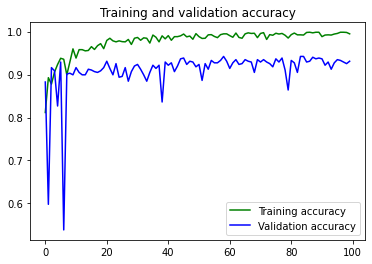

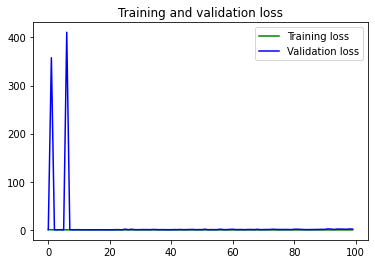

In [127]:
accuracy = classify_train1.history['accuracy']
val_accuracy = classify_train1.history['val_accuracy']
loss = classify_train1.history['loss']
val_loss = classify_train1.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [133]:

print(X_test.shape)
print(y_testHot.shape)
test_eval = full_model.evaluate(reZ(X_test,(128,128)), y_testHot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

(624, 288, 288, 1)
(624, 2)
20/20 [==============================] - 2s 77ms/step - loss: 98196.2344 - accuracy: 0.3750
Test loss: 98196.234375
Test accuracy: 0.375


In [138]:
predicted_classes = full_model.predict(reZ(X_test,(128,128)))

In [139]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels.shape

((624,), (624,))

In [146]:
correct = np.where(predicted_classes==test_labels)[0]
print ("Found " + str(len(correct)) + " correct labels")

Found 234 correct labels


In [148]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.38      1.00      0.55       234
     Class 1       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



NameError: name 'model' is not defined

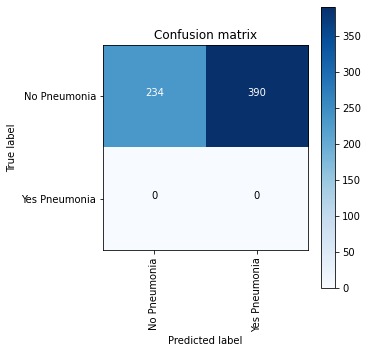

In [151]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    y_pred = model.predict(xtest)
    

confusion_mtx = confusion_matrix(predicted_classes,test_labels)
plot_confusion_matrix(confusion_mtx, classes = list({0: 'No Pneumonia', 1: 'Yes Pneumonia'}.values()))


https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363